# Convolutional Conditional neural process

## Loss function

The conditional neural process uses a neural network to model the conditional distribution $y_T | x_{T}, x_{C}, y_{C}$

$$ \mathcal{L} = \mathbb{E}_f \left[\mathbb{E}_N \left[ \log p(y_{1:N} | x_{1:N}, y_{1:K}) \right]\right]$$

In [37]:
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

import numpy as np
import matplotlib.pyplot as plt
import datetime

from utils import eq_covariance,              \
                  sample_1d_datasets_from_gp

In [38]:
x_min = -4.
x_max = 4.
num_datasets = 64
num_datapoints = 30
scale = 2e0
cov_coeff = 1e0
noise_coeff = 1e-2

x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                  x_max=x_max,
                                  num_datasets=num_datasets,
                                  num_datapoints=num_datapoints,
                                  scale=scale,
                                  cov_coeff=cov_coeff,
                                  noise_coeff=noise_coeff)

x, y = x[..., None], y[..., None]

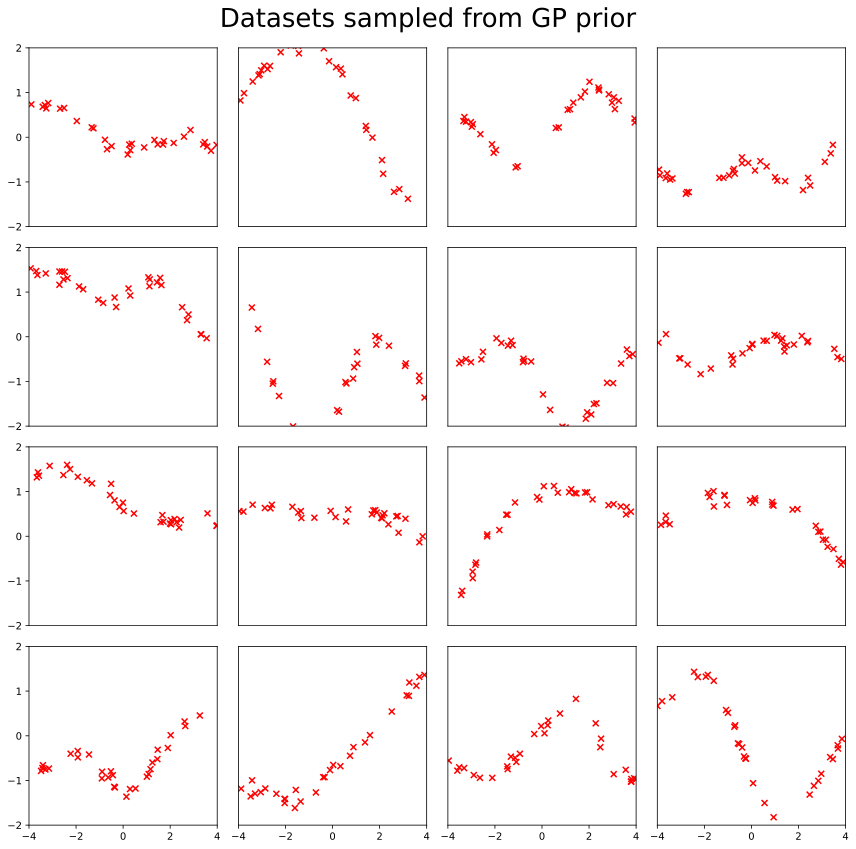

In [39]:
plt.figure(figsize=(12, 12))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.scatter(x[i, :, 0], y[i, :, 0], marker='x', color='red')
    
    plt.xlim([-4, 4])
    plt.ylim([-2, 2])
    
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-2, 2, 5))
    
    if i % 4 != 0:
        plt.yticks([])
        
    if i <= 11 != 0:
        plt.xticks([])

plt.suptitle('Datasets sampled from GP prior', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We define a CNP to be the collection of an `encoder` and a `decoder` object. The `encoder` will map the context points to a single context vector. The `decoder` will map the context vector and each of the target inputs, to distributions over the target outputs.

In [144]:
class ConvCNP(tf.Module):
    
    def __init__(self, encoder, decoder, name='conv_cnp', **kwargs):
        
        
        super().__init__(name=name, **kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def __call__(self, xc, yc, xt):
        
        f_params = self.encoder(xc, yc)
        yt_dist = self.decoder(xt, f_params)
        
        return yt_dist
    
    
    def loss(self, x, y, num_samples):
        
        num_batches = x.shape[0]
        batch_size = x.shape[1]
        
        loglik = 0
        
        for i in range(num_samples):
            
            n = batch_size#tf.cast((batch_size - 1) * tf.random.uniform(()), dtype=tf.int32) + 1
            
            xc = x[:, :n, ...]
            yc = y[:, :n, ...]
            
            yt_dist = self.__call__(xc, yc, x)
            
            loglik = loglik + tf.reduce_sum(yt_dist.log_prob(y))
         
        loss = - loglik / (num_batches * batch_size * num_samples)
        
        return loss

In [145]:
class CNN(tf.Module):
    
    def __init__(self,
                 input_channels,
                 output_channels,
                 hidden_channels,
                 kernel_size,
                 nonlinearity,
                 dtype,
                 name='convolutional_netork',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        
        channels = [input_channels] + hidden_channels + [output_channels]
        channels = [(c1, c2) for c1, c2 in zip(channels[:-1], channels[1:])]
        
        self.convs = []
        self.biases = []
        self.num_conv = len(channels)
        
        # Nonlinearity to use after each linear layer except the last
        self.nonlinearity = getattr(tf.nn, nonlinearity)
        
        with self.name_scope:
            for i, (c1, c2) in enumerate(channels):
                
                conv = tf.random.normal(mean=0.,
                                        stddev=(c1 * kernel_size) ** -0.5,
                                        shape=(kernel_size, c1, c2),
                                        dtype=dtype)
                
                bias = tf.random.normal(mean=0.,
                                        stddev=1.,
                                        shape=(1, 1, c2),
                                        dtype=dtype)
                
                self.convs.append(conv)
                self.biases.append(bias)
        
    
    def __call__(self, tensor):
        
        for i, (conv, bias) in enumerate(zip(self.convs, self.biases)):
            
            tensor = tf.nn.conv1d(tensor,
                                  conv,
                                  stride=1,
                                  padding='SAME')
            
            tensor = tensor + bias
            
            if i < self.num_conv - 1:
                tensor = self.nonlinearity(tensor)
        
        return tensor

In [255]:
class CNNEncoder(tf.Module):
    
    def __init__(self,
                 xmin,
                 xmax,
                 density,
                 cnn,
                 dtype,
                 name='conv_encoder',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        
        self.cnn = cnn
        
        self.grid = tf.linspace(xmin, xmax, int(density * (xmax - xmin)) + 1)
        
        self.rbf_log_scale = tf.Variable(tf.convert_to_tensor(density ** -2))

    
    def __call__(self, xc, yc):
        
        """
        xc (B, N, 1)
        yc (B, N, 1)
        """
        
        B = xc.shape[0]
        
        # Pass through first RBF mapping
        ones = tf.ones(shape=(yc.shape[:-1] + (1,)))
        ones_yc = tf.concat([ones, yc], axis=-1)
        
        phi = self.grid[None, None, :, None] - xc[:, :, None, :]
        phi = tf.reduce_sum((phi / tf.exp(self.rbf_log_scale)) ** 2, axis=-1)
        phi = tf.exp(-0.5 * phi)
        
        h = tf.einsum('bnd, bng -> bgd', ones_yc, phi)
        h = tf.stack([h[:, :, 0], h[:, :, 1] / (h[:, :, 0] + 1e-6)], axis=-1)
        
        # Pass through CNN
        f_params = self.cnn(h)
        
        return f_params
        
        
        
class CNNDecoder(tf.Module):
    
    def __init__(self,
                 xmin,
                 xmax,
                 density,
                 likelihood,
                 dtype,
                 name='conv_decoder',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        
        self.grid = np.linspace(xmin, xmax, int(density * (xmax - xmin)) + 1)
        self.grid = tf.convert_to_tensor(self.grid, dtype=dtype)
        
        self.rbf_log_scale = tf.Variable(tf.convert_to_tensor(density ** -1))
        self.likelihood = likelihood

    
    def __call__(self, xt, f_params):
        
        """
        xt        (B, N, 1)
        f_params  (B, N, 2)
        """
        
        psi = self.grid[None, None, :, None] - xt[:, :, None, :]
        psi = tf.reduce_sum((psi / tf.exp(self.rbf_log_scale)) ** 2, axis=-1)
        psi = tf.exp(-0.5 * psi)
        
        f_params = tf.einsum('bgd, bng -> bnd', f_params, psi)
        yt_dist = self.likelihood(f_params)
        
        return yt_dist

In [256]:
class GaussianLikelihood:
    
    def __init__(self, reparam_func, single_noise_param):
        
        self.dist = tfd.Normal
        
        if reparam_func == 'exp':
            self.reparam_func = tf.exp
            
        else:
            self.reparam_func = getattr(tf.nn, reparam_func)
        
        if single_noise_param:
            self.log_scale = tf.Variable(tf.zeros(()))
            
        self.single_noise_param = single_noise_param
        
    
    def __call__(self, param_tensor):
        
        loc, scale = self.reparametrise(param_tensor)
        dist = self.dist(loc=loc, scale=scale)
        
        return dist
        
        
    def reparametrise(self, tensor):
        
        mean = tensor[ ..., :1]
        scale = self.reparam_func(self.log_scale) * tf.ones_like(mean) \
                if self.single_noise_param else self.reparam_func(tensor[..., 1:2])
        
        return mean, scale
    
    
    def loglik(self, param_tensor, data):
        return self.__call__().log_prob(data)

In [257]:
tf.random.set_seed(1)

input_channels = 2
output_channels = 2
hidden_channels = []
kernel_size = 5
nonlinearity = 'relu'
dtype = tf.float32

xmin = -10.
xmax = 10.
density = 20

cnn = CNN(input_channels=input_channels,
          output_channels=output_channels,
          hidden_channels=hidden_channels,
          kernel_size=kernel_size,
          nonlinearity=nonlinearity,
          dtype=dtype)

cnn_encoder = CNNEncoder(xmin=xmin,
                         xmax=xmax,
                         density=density,
                         cnn=cnn,
                         dtype=dtype)

decoder_likelihood = GaussianLikelihood(reparam_func='exp',
                                        single_noise_param=False)

cnn_decoder = CNNDecoder(xmin=xmin,
                         xmax=xmax,
                         density=density,
                         likelihood=decoder_likelihood,
                         dtype=dtype)

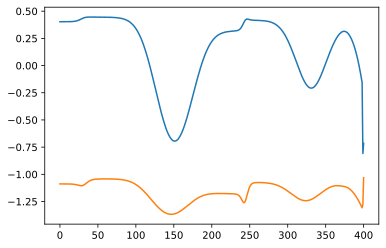

In [260]:
x = 0.5 * xmin + (xmax - xmin) * tf.random.uniform(shape=(1, 10, 1), dtype=dtype)
y = 2 * tf.random.uniform(shape=(1, 10, 1), dtype=dtype) - 1

conv_cnp = ConvCNP(encoder=cnn_encoder, decoder=cnn_decoder)

encoding = cnn_encoder(x, y)
plt.plot(encoding.numpy()[0, :])
plt.show()

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[9.9985367e-01],
        [9.9981093e-01],
        [6.2976022e-28],
        [1.4856308e-06],
        [4.2047963e-30],
        [6.7670673e-02],
        [3.6708650e-03],
        [2.7374318e-01],
        [2.1909435e-30],
        [8.7373698e-01]]], dtype=float32)>